# This code is trial for getting one day prediction at a time and increase the training set after that 


# Import Libraries


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import RobustScaler
from keras.models import load_model

2025-03-21 15:47:40.952508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-21 15:47:40.964320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-21 15:47:40.967947: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 15:47:40.978791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Check for GPU 


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Force CPU usage


GPU memory growth enabled


I0000 00:00:1742550464.182562  373829 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742550464.223584  373829 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742550464.223852  373829 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


# Hyperparameter


In [3]:

split = 0.85
sequence_length = 60
epochs = 50
learning_rate = 0.0001

In [5]:
# Define buffer size (number of past samples to keep)
buffer_size = sequence_length  

# Initialize empty buffers
data_buffer_X = []  # Stores input features
data_buffer_y = []  # Stores target values (labels)


# Loading stock price data

In [6]:
# stock_data = pd.read_csv("stock_price.csv")
stock_data = pd.read_csv("gold_price.csv")
column = ['Close']
columns_to_load = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


# Data preparation

In [7]:
len_stock_data = stock_data.shape[0]
train_examples = int(len_stock_data * split)

train = stock_data.get(column).values[:train_examples]
test = stock_data.get(column).values[train_examples:]

len_train = train.shape[0]
len_test = test.shape[0]

# EMA SCALER



In [8]:
# import numpy as np

# class EMAScaler:
#     def __init__(self, alpha=0.1):
#         """
#         Initialize the Exponential Moving Average Scaler.
#         :param alpha: Smoothing factor (0 < alpha <= 1). Higher values give more weight to recent data.
#         """
#         self.alpha = alpha
#         self.mean = None
#         self.var = None

#     def partial_fit(self, X):
#         """
#         Update the scaler with new data.
#         :param X: New data (numpy array or similar).
#         """
#         mean_new = np.mean(X, axis=0)
#         var_new = np.var(X, axis=0)

#         if self.mean is None:
#             self.mean = mean_new
#             self.var = var_new
#         else:
#             self.mean = self.alpha * mean_new + (1 - self.alpha) * self.mean
#             self.var = self.alpha * var_new + (1 - self.alpha) * self.var

#     def transform(self, X):
#         """
#         Scale the input data using the current mean and variance.
#         :param X: Data to be scaled.
#         :return: Scaled data.
#         """
#         return (X - self.mean) / np.sqrt(self.var + 1e-8)

#     def fit_transform(self, X):
#         """
#         Update the scaler and transform the data in one step.
#         :param X: Data to be scaled.
#         :return: Scaled data.
#         """
#         self.partial_fit(X)
#         return self.transform(X)

# Scaling with EMA scaler


In [9]:
# scaler = EMAScaler(alpha=0.1)
# train_scaled = scaler.fit_transform(train.reshape(-1, 1))
# test_scaled = scaler.transform(test.reshape(-1, 1))

In [10]:
# train_scaled = np.log1p(train.reshape(-1, 1))
# test_scaled = np.log1p(test.reshape(-1, 1))
# scaler = RobustScaler()
# scaler.fit(train)  

# scaled_train = scaler.transform(train)
# scaled_test = scaler.transform(test)

# train_scaled = train/1e5
# test_scaled = test/1e5
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.partial_fit(train)
# train_scaled = scaler.transform(train)
# test_scaled = scaler.transform(test)




# Initialize and fit scaler

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))


In [12]:
print(train_scaled[0:len_train])
print(test_scaled[0:len_test])

[[0.67359159]
 [0.74168946]
 [0.76546611]
 [0.69759903]
 [0.66389641]
 [0.47576164]
 [0.52770069]
 [0.54847631]
 [0.49930723]
 [0.48245606]
 [0.41920578]
 [0.52493072]
 [0.56532775]
 [0.54132031]
 [0.56394249]
 [0.54339793]
 [0.51823629]
 [0.51477369]
 [0.51154187]
 [0.56832851]
 [0.55216969]
 [0.49492149]
 [0.48891942]
 [0.4014312 ]
 [0.45221605]
 [0.51131109]
 [0.51292686]
 [0.50807927]
 [0.47229903]
 [0.46283464]
 [0.38180978]
 [0.35941811]
 [0.33217913]
 [0.37765454]
 [0.43674958]
 [0.42797782]
 [0.41805158]
 [0.34095089]
 [0.26939042]
 [0.2054478 ]
 [0.25300082]
 [0.19875337]
 [0.16204972]
 [0.19459814]
 [0.1518927 ]
 [0.21514297]
 [0.2428438 ]
 [0.22045241]
 [0.25184662]
 [0.25831026]
 [0.26523547]
 [0.28947369]
 [0.28116322]
 [0.27100647]
 [0.24076618]
 [0.24722982]
 [0.2592334 ]
 [0.23291784]
 [0.21168037]
 [0.20914118]
 [0.14612169]
 [0.19944601]
 [0.24815324]
 [0.24584483]
 [0.28231742]
 [0.26685124]
 [0.3010157 ]
 [0.27793168]
 [0.26177287]
 [0.27908588]
 [0.27631563]
 [0.34

In [13]:
print("Last 10 data of train set ")
print(train_scaled[-10:])
print("\n\n\first 10 data of test set ")
print(test_scaled[:10])
print("\n\n\n")

Last 10 data of train set 
[[0.67636184]
 [0.69990743]
 [0.70313925]
 [0.7199907 ]
 [0.78647252]
 [0.78023994]
 [0.77008292]
 [0.80424738]
 [0.82317617]
 [0.81555833]]


irst 10 data of test set 
[[0.78808857]
 [0.79616797]
 [0.76777451]
 [0.79824531]
 [0.75023071]
 [0.7504615 ]
 [0.78208649]
 [0.79524456]
 [0.75715592]
 [0.72437644]]






# Prepare training data



In [14]:
X_train = []
y_train = []
for i in range(len_train - sequence_length):
    X_train.append(train_scaled[i:i + sequence_length].flatten())
    y_train.append(train_scaled[i + sequence_length])
X_train = np.array(X_train)
y_train = np.array(y_train)

# data_buffer_X.append(X_train[0:9])

# data_buffer_y.append(y_train[0:9])

In [15]:
print(X_train[-1])
print(y_train[-1])
print("\n\n\n")

[0.83310241 0.86634317 0.87119104 0.85457038 0.8460294  0.83033216
 0.86403477 0.91574304 0.98014752 0.98337934 0.92820847 0.93767286
 0.95083092 0.95498588 0.90974125 0.90812548 0.84949201 0.83841156
 0.77585392 0.78393333 0.83125557 0.81255757 0.81948278 0.74492128
 0.75669407 0.74399786 0.77977809 0.7913201  0.82340695 0.7550783
 0.78578016 0.78162493 0.74515206 0.79570612 0.7832407  0.78531831
 0.75207727 0.74168946 0.78716515 0.78070151 0.72760826 0.69159724
 0.68859621 0.69829166 0.70775606 0.67382266 0.66828244 0.6652814
 0.68674965 0.69967665 0.66689745 0.67636184 0.69990743 0.70313925
 0.7199907  0.78647252 0.78023994 0.77008292 0.80424738 0.82317617]
[0.81555833]






# Prepare test data



In [16]:
X_test = []
y_test = []
for i in range(len_test - sequence_length):
    X_test.append(test_scaled[i:i + sequence_length].flatten())
    y_test.append(test_scaled[i + sequence_length])
X_test = np.array(X_test)
y_test = np.array(y_test)

In [17]:
print(X_test[:1])
print(y_test[:1])
print("\n\n\n")

[[0.78808857 0.79616797 0.76777451 0.79824531 0.75023071 0.7504615
  0.78208649 0.79524456 0.75715592 0.72437644 0.72599249 0.74007369
  0.71860543 0.70406267 0.69413643 0.67543843 0.66689745 0.65927961
  0.65581701 0.63088615 0.62650041 0.63065537 0.63296377 0.6675898
  0.69159724 0.69113567 0.68120943 0.68674965 0.72853168 0.74792231
  0.76084931 0.72483829 0.70106163 0.68605702 0.70083085 0.69852245
  0.69344408 0.66920585 0.6523544  0.69967665 0.71052603 0.72391487
  0.75069228 0.70083085 0.70406267 0.68374862 0.65697121 0.57987052
  0.58887334 0.56301935 0.51638946 0.47229903 0.46491226 0.47530007
  0.45844862 0.51269607 0.5461679  0.57502293 0.58702651 0.59349015]]
[[0.66943664]]






# Store original y_test values for evaluation


In [18]:
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))


In [19]:
# y_test_original = np.expm1(y_test.reshape(-1, 1))
# y_test_original = y_test*1e5
# y_test_original = scaler.inverse_transform(y_test)


# XAU_USD15 DATASET


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the new dataset
stock_data = pd.read_csv("XAU_15m_data.csv", delimiter=";")

# Convert the 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%Y.%m.%d %H:%M')

# Sort the data by date (if not already sorted)
stock_data = stock_data.sort_values(by='Date')

# Extract only the 'Close' column
close_prices = stock_data['Close'].values.reshape(-1, 1)  # Reshape to 2D array for scaling

# Split the data into training and testing sets
split = 0.8  # Example value, adjust as needed
len_stock_data = len(close_prices)
train_examples = int(len_stock_data * split)

train = close_prices[:train_examples]
test = close_prices[train_examples:]

len_train = len(train)
len_test = len(test)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define sequence length (same as in the original code)
sequence_length = 60  # Example value, adjust as needed

# Create sequences for training data
X_train = []
y_train = []
for i in range(len_train - sequence_length):
    X_train.append(train_scaled[i:i + sequence_length].flatten())  # Flatten the sequence
    y_train.append(train_scaled[i + sequence_length])
X_train = np.array(X_train)
y_train = np.array(y_train)

# Create sequences for testing data
X_test = []
y_test = []
for i in range(len_test - sequence_length):
    X_test.append(test_scaled[i:i + sequence_length].flatten())  # Flatten the sequence
    y_test.append(test_scaled[i + sequence_length])
X_test = np.array(X_test)
y_test = np.array(y_test)

# Inverse transform for original values (if needed)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Direction Accuracy Method


In [5]:
def calculate_direction_accuracy(actual_values, predicted_values):
    """
    Calculate accuracy of predicted price movement direction
    Returns: accuracy and arrays of actual and predicted directions
    """
    # Calculate actual price movements (1 for up, 0 for down)
    actual_direction = (actual_values[1:] > actual_values[:-1]).astype(int)

    # Calculate predicted price movements (1 for up, 0 for down)
    predicted_direction = (predicted_values[1:] > predicted_values[:-1]).astype(int)

    # Calculate accuracy
    direction_accuracy = np.mean(actual_direction == predicted_direction)

    return direction_accuracy, actual_direction, predicted_direction


# Model



In [22]:
# def model_create(X_train1, y_train1):
#     tf.random.set_seed(1234)

#     model = tf.keras.models.Sequential(
#         [
#             tf.keras.Input(shape=(X_train.shape[1],)),
#             tf.keras.layers.Dense(units=50, activation="relu"),
#             tf.keras.layers.Dropout(0.1),
#             tf.keras.layers.Dense(units=30, activation="relu"),
#             tf.keras.layers.Dropout(0.05),
#             tf.keras.layers.Dense(units=20, activation="relu"),
#             tf.keras.layers.Dropout(0.01),
#             tf.keras.layers.Dense(units=1, activation="linear")
#         ]
#     )

#     model.compile(
#         loss=tf.keras.losses.MeanSquaredError(),
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     )

#     early_stopping = tf.keras.callbacks.EarlyStopping(
#         monitor='loss',
#         patience=5,
#         restore_best_weights=True
#     )

#     model.fit(
#         X_train1, y_train1,
#         epochs=epochs,
#         batch_size=32,
#         callbacks=[early_stopping],
#         verbose=0
#     )
#     return model


In [30]:
#creating LSTM model
def model_create(X_train1, y_train1):
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 50, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.LSTM(units = 20, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    # model.compile(
    #     loss = tf.keras.losses.mean_squared_error,
    #     optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # )

    model.compile(
    loss=tf.keras.losses.MeanSquaredError(),  # Instantiate the loss class
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    )


    model.fit(
        X_train, y_train,
        epochs = epochs,
        batch_size = 4048,
        verbose=0
    )
    return model

# Update Model


In [24]:
def update_model(model, X_new, y_new):
    """
    Update the model with new data while keeping a buffer of old data.
    
    Parameters:
    - model: The trained TensorFlow/Keras model
    - X_new: New input data (features)
    - y_new: New output data (targets)
    
    Returns:
    - Updated model
    """
    global data_buffer_X, data_buffer_y  # Use global buffers

    # Convert new data to list format (if needed)
    X_new, y_new = list(X_new), list(y_new)

    # Add new data to buffer
    data_buffer_X.extend(X_new)
    data_buffer_y.extend(y_new)

    # Keep only the last `buffer_size` samples
    # if len(data_buffer_X) > buffer_size:
    #     data_buffer_X = data_buffer_X[-buffer_size:]  # Remove old data
    #     data_buffer_y = data_buffer_y[-buffer_size:]

    # Convert buffers to NumPy arrays
    X_train = np.array(data_buffer_X)
    y_train = np.array(data_buffer_y)

    # Train the model on buffered data
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

    return model  # Return updated model


# Evaluation 
## With the graphs 

In [6]:

def evaluate(predictions):
    mae = mean_absolute_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)

    # Calculate direction accuracy
    dir_acc, actual_dir, pred_dir = calculate_direction_accuracy(y_test_original, predictions)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Price predictions
    ax1.plot(y_test_original, label="Actual Values", color="blue", marker='o')
    ax1.plot(predictions, label="Predicted Values", color="red",
            linestyle='dashed', marker='x')
    ax1.set_title("Comparison of Predicted vs Actual Values")
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Direction predictions
    ax2.plot(actual_dir, label="Actual Direction", color="blue", marker='o')
    ax2.plot(pred_dir, label="Predicted Direction", color="red",
            linestyle='dashed', marker='x')
    ax2.set_title("Comparison of Predicted vs Actual Price Direction (1=Up, 0=Down)")
    ax2.set_xlabel("Sample Index")
    ax2.set_ylabel("Direction")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return mae, mape, (1 - mape), dir_acc

# Run Model 


In [37]:

def run_model(n):
    total_mae = total_mape = total_acc = total_dir_acc = 0
    results = np.zeros((len_test - sequence_length, 1))

    global data_buffer_X, data_buffer_y

    for iteration in range(n):
        # Create and train initial model
        model = model_create(X_train, y_train)
        model.save(f'model(split.8)_after_training_iter_{iteration}.h5')


        for j in range(len_test - sequence_length):
            current_input = X_test[j].reshape(1, sequence_length)
            prediction = model.predict(current_input, verbose=0)
            results[j] = scaler.inverse_transform(prediction.reshape(-1, 1))
            # results[j] = np.expm1(prediction.reshape(-1, 1))
            # results[j] = prediction*1e5
            # results[j] = scaler.inverse_transform(prediction)
            # Add new sample to buffer
#             actual = y_test[j].reshape(1, 1)
# # Add new data to buffer
#             if len(data_buffer_X) >= sequence_length:
#                 # Remove first element if buffer is full
#                 data_buffer_X.pop(0)
#                 data_buffer_y.pop(0)
            
#             # # Append new data
#             # data_buffer_X.append(current_input)
#             # data_buffer_y.append(actual)
            
#             # # Update model if we have at least some minimum data
#             # min_samples_to_train = 10  # You can adjust this value
#             # if len(data_buffer_X) >= min_samples_to_train:
#             #     # Convert buffer to NumPy arrays
#             #     X_train_new = np.vstack(data_buffer_X)
#             #     y_train_new = np.vstack(data_buffer_y)
                
#                 # Update the model with buffered data
#             model = update_model(model, current_input, actual)
    

            if j < len_test - sequence_length - 1:
                actual = y_test[j].reshape(1, 1)
                model.fit(current_input,
                         actual,
                         epochs=20,
                         verbose=0)
                
        model.save(f'model_after(split.8)_process_iter_{iteration}.h5')

        mae, mape, acc, dir_acc = evaluate(results)
        total_mae += mae
        total_mape += mape
        total_acc += acc
        total_dir_acc += dir_acc

        print(f"Iteration {iteration + 1}:")
        print(f"MAE: {mae}")
        print(f"MAPE: {mape}")
        print(f"Price Accuracy: {acc}")
        print(f"Direction Accuracy: {dir_acc}\n")

    return (total_mae/n), (total_mape/n), (total_acc/n), (total_dir_acc/n), results.tolist()


# Main


In [ ]:
print("Starting model training and evaluation...")
mae, mape, acc, dir_acc, preds = run_model(1)

print("\nFinal Results:")
print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}")
print(f"Price Accuracy = {acc}")
print(f"Direction Accuracy = {dir_acc}")

Starting model training and evaluation...


In [9]:
def evalu(predictions, y_test_original):
    mae = mean_absolute_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)

    # Calculate direction accuracy
    dir_acc, actual_dir, pred_dir = calculate_direction_accuracy(y_test_original, predictions)
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"Price Accuracy: {1 - mape}")
    print(f"Direction Accuracy: {dir_acc}\n")

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Price predictions
    ax1.plot(y_test_original, label="Actual Values", color="blue", marker='o')
    ax1.plot(predictions, label="Predicted Values", color="red",
            linestyle='dashed', marker='x')
    ax1.set_title("Comparison of Predicted vs Actual Values")
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Direction predictions
    ax2.plot(actual_dir, label="Actual Direction", color="blue", marker='o')
    ax2.plot(pred_dir, label="Predicted Direction", color="red",
            linestyle='dashed', marker='x')
    ax2.set_title("Comparison of Predicted vs Actual Price Direction (1=Up, 0=Down)")
    ax2.set_xlabel("Sample Index")
    ax2.set_ylabel("Direction")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [16]:
preds = np.array(preds)
evalu(preds[-100:], y_test_original[-100:])


NameError: name 'preds' is not defined

# Testing the load model


In [ ]:
def use_trained_model(data, iteration=0):
    # Load the model
    model = load_model(f'model_after_training_iter_{iteration}.h5')
    
    # Prepare your data (ensure it has the same shape as during training)
    input_data = data.reshape(1, sequence_length)
    
    # Make prediction
    prediction = model.predict(input_data, verbose=0)
    
    # Transform prediction back to original scale
    result = scaler.inverse_transform(prediction.reshape(-1, 1))
    
    return result

# Load and use the model saved after the whole process
def use_final_model(data, iteration=0):
    # Load the model
    model = load_model(f'model_after_process_iter_{iteration}.h5')
    
    # Prepare your data
    input_data = data.reshape(1, sequence_length)
    
    # Make prediction
    prediction = model.predict(input_data, verbose=0)
    
    # Transform prediction back to original scale
    result = scaler.inverse_transform(prediction.reshape(-1, 1))
    
    return result

# Example usage:
# Assuming you have some new data to predict
new_data = X_test[0]  # Just an example

# Using the model saved after training
prediction1 = use_trained_model(new_data, iteration=0)
print("Prediction using model after training:", prediction1)

# Using the model saved after the whole process
prediction2 = use_final_model(new_data, iteration=0)
print("Prediction using model after whole process:", prediction2)


Prediction using model after training: [[1842.6292]]
Prediction using model after whole process: [[1949.0063]]


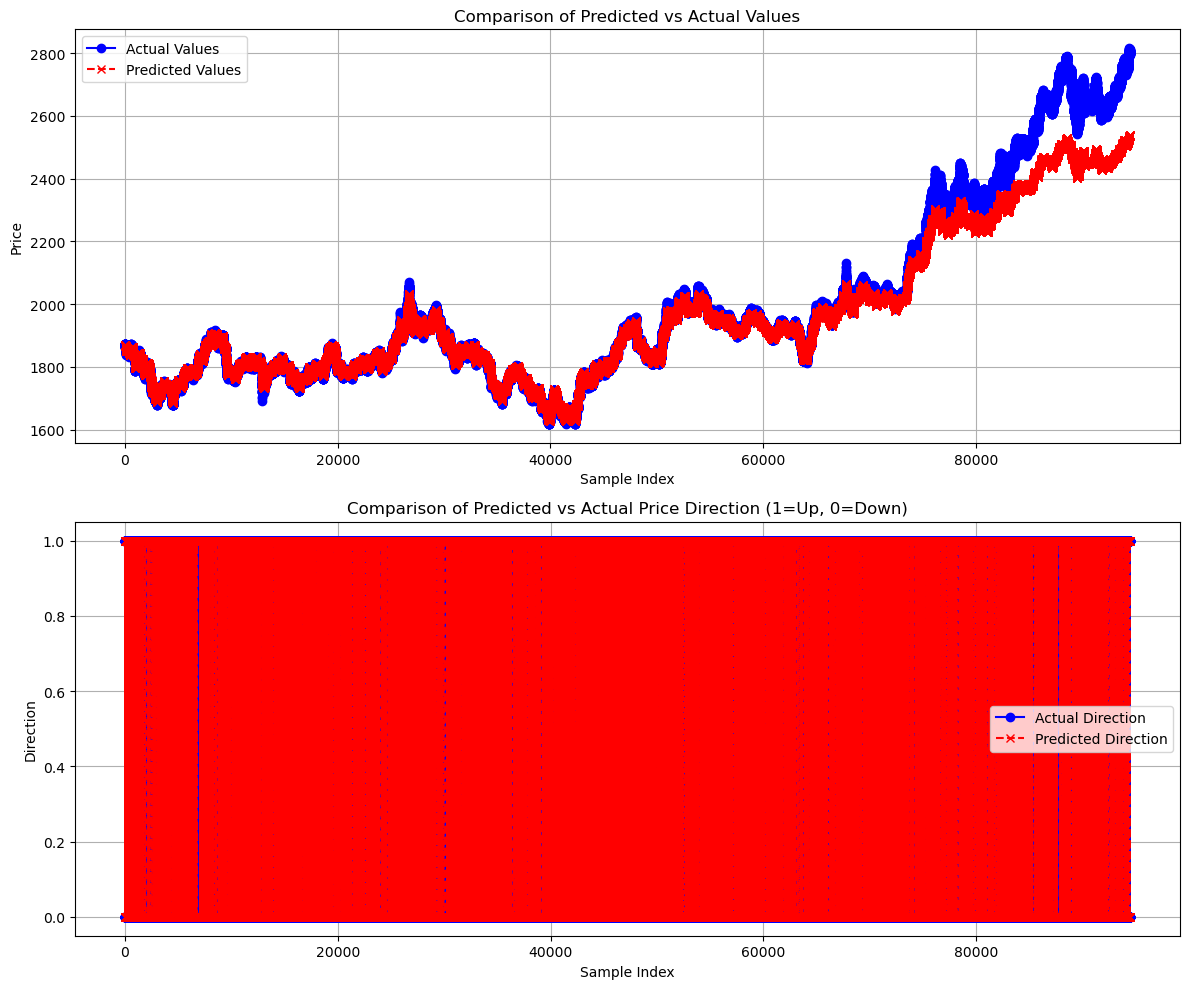

MAE: 35.39288660845793
MAPE: 0.014541551243376626
Price Accuracy: 0.9854584487566234
Direction Accuracy: 0.49668102946314197



In [15]:
model = load_model(f'model(split.8)_after_training_iter_0.h5')
total_mae = total_mape = total_acc = total_dir_acc = 0
something = len_test - sequence_length
results = np.zeros((something, 1))
for j in range((something)):
        current_input = X_test[j].reshape(1, sequence_length)
        prediction = model.predict(current_input, verbose=0)
        results[j] = scaler.inverse_transform(prediction.reshape(-1, 1))

mae, mape, acc, dir_acc = evaluate(results)
total_mae += mae
total_mape += mape
total_acc += acc
total_dir_acc += dir_acc

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"Price Accuracy: {acc}")
print(f"Direction Accuracy: {dir_acc}\n")

        

In [10]:
preds = np.array(preds)
evalu(preds[-100:], y_test_original[-100:])


NameError: name 'preds' is not defined